/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Event Clustering Summary:
      x     y  EventCluster
0  84.2  63.2             1
1  73.8  44.6             2
2  76.0  69.1             1
3  77.4  58.7             2
4  88.7  50.5             3


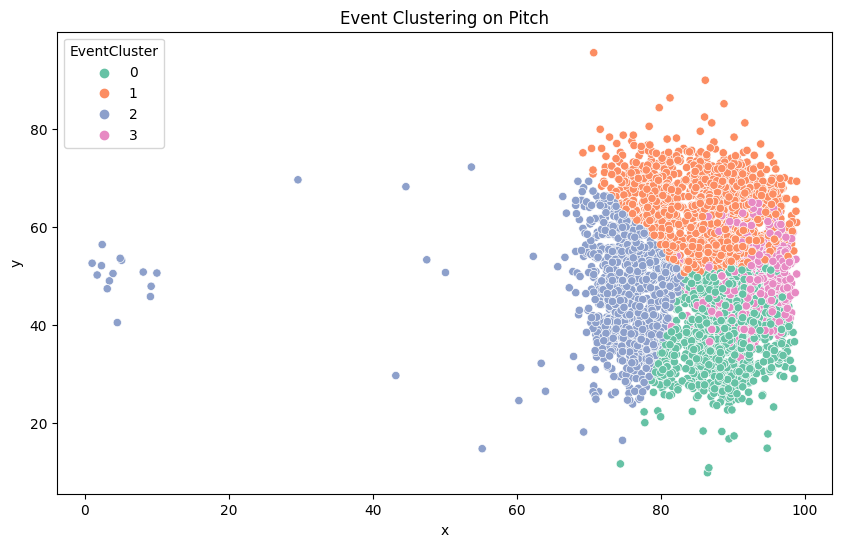

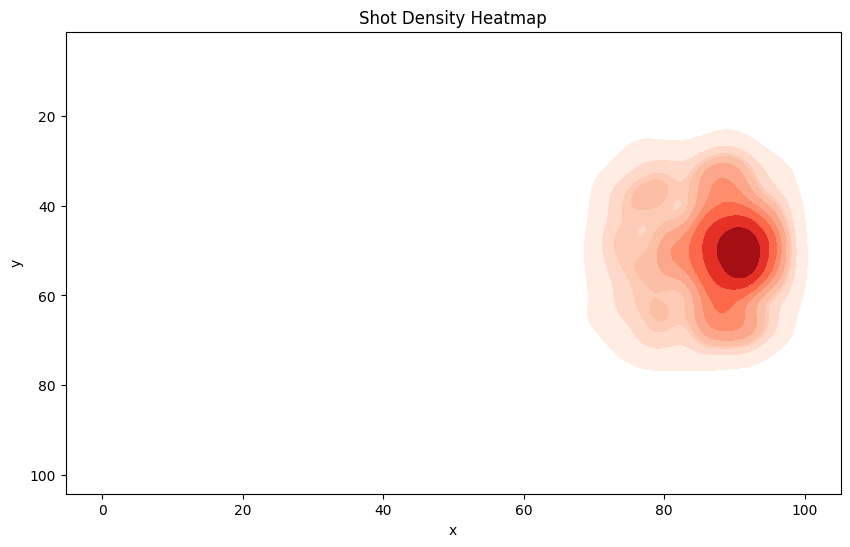

Zone Efficiency:
PitchZone
Central Zone    0.090909
Left Zone       0.933333
Right Zone      0.121998
dtype: float64


ValueError: could not convert string to float: 'LeftFoot'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Load dataset
file_path = "/Users/marclambertes/Downloads/Outswinger FC - Expected Goals/Bundesliga xG 04022025.xlsx"  # Update with your file path
df = pd.read_excel(file_path)

# Ensure relevant columns are numeric
df[['x', 'y', 'xG', 'distance', 'angle']] = df[['x', 'y', 'xG', 'distance', 'angle']].apply(pd.to_numeric, errors='coerce').fillna(0)

### 1. Event Clustering ###
# Prepare the data for clustering (using x, y, and shot quality)
clustering_data = df[['x', 'y', 'xG']]
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['EventCluster'] = kmeans.fit_predict(clustering_data_scaled)

print("Event Clustering Summary:")
print(df[['x', 'y', 'EventCluster']].head())

# Visualize clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='EventCluster', palette='Set2', data=df)
plt.title("Event Clustering on Pitch")
plt.show()

### 2. Tactical Heatmaps ###
plt.figure(figsize=(10, 6))
# Heatmap for shot locations
sns.kdeplot(data=df, x='x', y='y', cmap='Reds', fill=True)
plt.title('Shot Density Heatmap')
plt.gca().invert_yaxis()  # Invert to match pitch orientation
plt.show()

### 3. Zone Efficiency Metrics ###
# Define pitch zones
conditions = [
    (df['x'] <= 33),  # Left third
    (df['x'] > 33) & (df['x'] <= 66),  # Central third
    (df['x'] > 66)  # Right third
]
zone_names = ['Left Zone', 'Central Zone', 'Right Zone']
df['PitchZone'] = np.select(conditions, zone_names, default='Unknown')

# Zone efficiency calculation
def calculate_efficiency(group):
    total_attempts = group.shape[0]
    successful_goals = group['isGoal'].sum()
    return successful_goals / total_attempts if total_attempts > 0 else 0

zone_efficiency = df.groupby('PitchZone').apply(calculate_efficiency)
print("Zone Efficiency:")
print(zone_efficiency)

### 4. Predictive Modeling ###
# Outcome Prediction Model (Logistic Regression)
X = df[['xG', 'distance', 'angle', 'Bodypart']].replace({'Head': 1, 'Foot': 0})
y = df['isGoal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Player Performance Prediction (Random Forest)
player_features = ['xG', 'distance', 'angle', 'Bodypart']
X_player = df[player_features]
y_player = df['Goal']  # Predict total goals

X_player_train, X_player_test, y_player_train, y_player_test = train_test_split(X_player, y_player, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_player_train, y_player_train)
y_player_pred = rf_model.predict(X_player_test)

print("Random Forest Player Performance Accuracy:", accuracy_score(y_player_test, y_player_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_player_test, y_player_pred))
